Head of the DataFrame:
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

DataFrame with date as index:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

Info of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None

--- Forecast Accuracy Metrics (Drift Method) ---
Mean Squared Error (MSE): 8587.05
Root Mean Squared Error (RMSE): 92.67
Mean Absolute Percentage Error (MAPE): 12.42%


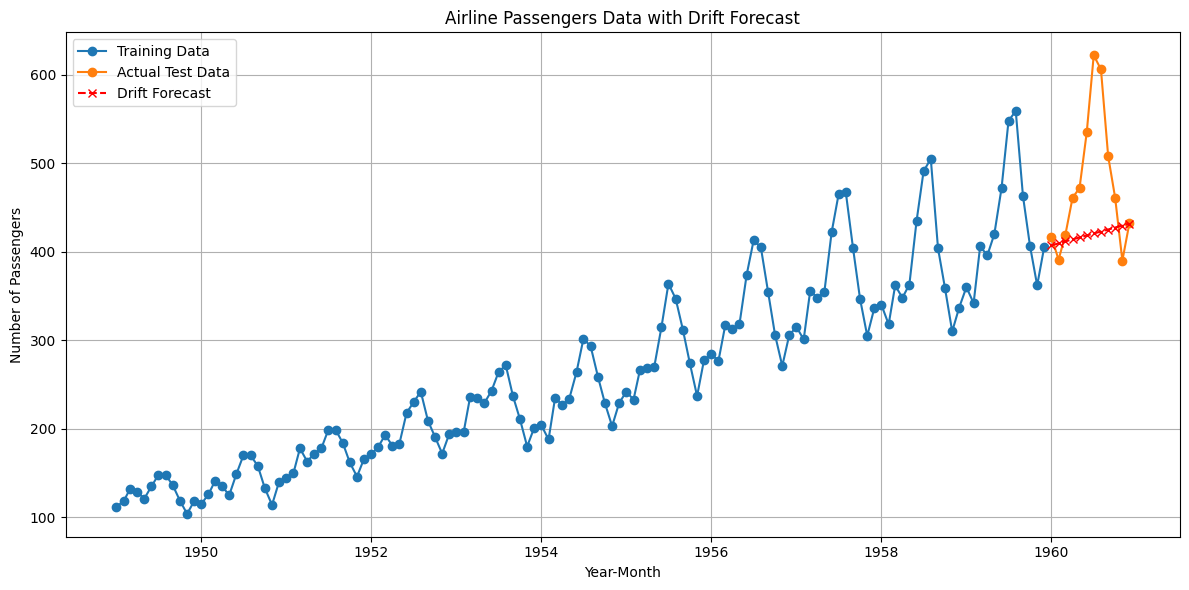


--- Drift Calculation Details ---
First value: 112
Last value: 405
Total change: 293
Number of periods: 132
Calculated drift per period: 2.24


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Configuration ---
file_path = 'C:/Users/USER/Downloads/AirPassengers.csv'  # Update with your actual file path
date_column = 'Month'               # Column with dates
value_column = '#Passengers'        # Column with passenger counts
date_format = '%Y-%m'               # Date format in your CSV
forecast_period = 12                # Number of months to forecast (reduced from 36 for better visualization)

# --- Load the dataset ---
try:
    df = pd.read_csv(file_path)
    print("Head of the DataFrame:")
    print(df.head())

    # Convert the date column to datetime objects and set as index
    df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    df.set_index(date_column, inplace=True)
    df = df.dropna()

    print("\nDataFrame with date as index:")
    print(df.head())
    print("\nInfo of the DataFrame:")
    print(df.info())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except KeyError as e:
    print(f"Error: Column '{e}' not found in the CSV file. Please check the column names.")
    exit()
except ValueError as e:
    print(f"Error: Could not parse date. Please check the 'date_format' variable. Details: {e}")
    exit()

# --- Split data into training and testing sets ---
# Using the last 'forecast_period' months as test data
train_data = df.iloc[:-forecast_period]
test_data = df.iloc[-forecast_period:]

# --- Implement Drift Method (without statsmodels) ---
def calculate_drift_forecast(series, periods):
    """
    Calculates drift forecast without external dependencies
    """
    if len(series) < 2:
        return [series.iloc[-1]] * periods
    
    # Calculate drift (average change between first and last point)
    y = series.values
    n = len(y)
    total_change = y[-1] - y[0]
    drift = total_change / (n - 1)
    
    # Generate forecast
    last_value = y[-1]
    return [last_value + (i + 1) * drift for i in range(periods)]

# Generate forecast
drift_forecast_values = calculate_drift_forecast(train_data[value_column], forecast_period)
drift_forecast_series = pd.Series(
    drift_forecast_values,
    index=pd.date_range(
        start=train_data.index[-1] + pd.DateOffset(months=1),
        periods=forecast_period,
        freq='MS'
    )
)

# --- Calculate forecast accuracy metrics ---
mse = mean_squared_error(test_data[value_column], drift_forecast_series)
rmse = sqrt(mse)
mape = 100 * (abs(test_data[value_column] - drift_forecast_series) / test_data[value_column]).mean()

print("\n--- Forecast Accuracy Metrics (Drift Method) ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# --- Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data[value_column], label='Training Data', marker='o')
plt.plot(test_data.index, test_data[value_column], label='Actual Test Data', marker='o')
plt.plot(drift_forecast_series.index, drift_forecast_series, 
         label='Drift Forecast', color='red', linestyle='--', marker='x')
plt.title('Airline Passengers Data with Drift Forecast')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Additional Analysis ---
print("\n--- Drift Calculation Details ---")
print(f"First value: {train_data[value_column].iloc[0]}")
print(f"Last value: {train_data[value_column].iloc[-1]}")
print(f"Total change: {train_data[value_column].iloc[-1] - train_data[value_column].iloc[0]}")
print(f"Number of periods: {len(train_data)}")
print(f"Calculated drift per period: {(train_data[value_column].iloc[-1] - train_data[value_column].iloc[0]) / (len(train_data) - 1):.2f}")